In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df_polars_knn = pl.read_csv("balanced_knn_metrics_output.csv", separator=";")
df_polars_lr = pl.read_csv("balanced_lr_metrics_output.csv", separator=";")
df_polars_svm = pl.read_csv("balanced_svm_metrics_output.csv", separator=";")
df_polars_rf = pl.read_csv("balanced_rf_metrics_output.csv", separator=";")
df_polars_bayes = pl.read_csv("balanced_bayes_metrics_output.csv", separator=";")
df_polars_dt = pl.read_csv("balanced_dt_metrics_output.csv", separator=";")
df_polars_AE = pl.read_csv("balanced_AE_metrics_output.csv", separator=";")
df_polars_mlp = pl.read_csv("balanced_mlp_metrics_output.csv", separator=";")
df_polars_2dcnn = pl.read_csv("balanced_2DCNN_metrics_output.csv", separator=";")

In [3]:
lista = [df_polars_knn, df_polars_lr, df_polars_svm, df_polars_rf, df_polars_bayes,df_polars_dt, df_polars_AE, df_polars_mlp, df_polars_2dcnn]
medias = []
desvios = []
medianas = []
ic_superiores = []
ic_inferiores = []


In [4]:
def gerar_media(df):
    algoritmo = df[0,0]
    #print(algoritmo)
    mean_values = df.select([
    pl.col("*").mean()
])
    mean_values[0,0] = algoritmo
    return mean_values

In [5]:
def gerar_desvio(df):
    algoritmo = df[0, 0]
    
    df = df.with_columns(
        pl.lit(1).alias(df.columns[0])
    )
    
    std_values = df.select([
        pl.col("*").std()
    ])
        
    std_values = std_values.with_columns(
        pl.lit(algoritmo).alias(df.columns[0])
    )
    return std_values

In [6]:
def gerar_mediana(df):
    algoritmo = df[0, 0]
    
    df = df.with_columns(
        pl.lit(1).alias(df.columns[0])
    )
    
    median_values = df.select([
        pl.col("*").median()
    ])
    
    median_values = median_values.with_columns(
        pl.lit(algoritmo).alias(df.columns[0])
    )
    return median_values

In [7]:
def gerar_intervalo_confianca(df_medias_unificadas, df_desvios_unificados):
    # Armazenando toda a primeira coluna (algoritmo) de df_medias_unificadas
    algoritmo = df_medias_unificadas[:, 0]  # Pega toda a primeira coluna
    
    # Substitui todos os valores da primeira coluna por 1
    df_medias_unificadas = df_medias_unificadas.with_columns(
        pl.lit(1).alias(df_medias_unificadas.columns[0])
    )
    df_desvios_unificados = df_desvios_unificados.with_columns(
        pl.lit(1).alias(df_desvios_unificados.columns[0])
    )
    
    # Número de amostras
    n = 30  # Ou qualquer valor adequado
    

    # Calculando o intervalo de confiança usando os DataFrames unificados
    ic_superior = df_medias_unificadas + 1.96 * df_desvios_unificados / np.sqrt(n)  # IC superior
    ic_inferior = df_medias_unificadas - 1.96 * df_desvios_unificados / np.sqrt(n)  # IC inferior
    
    # Restaurando os valores da primeira coluna (algoritmo) nos dois DataFrames
    nome_coluna = df_medias_unificadas.columns[0]  # Nome da primeira coluna
    ic_superior = ic_superior.with_columns(pl.lit(algoritmo).alias(nome_coluna))
    ic_inferior = ic_inferior.with_columns(pl.lit(algoritmo).alias(nome_coluna))
    
    return ic_superior, ic_inferior


In [8]:
for i in lista:
    medias.append(gerar_media(i))
    desvios.append(gerar_desvio(i))
    medianas.append(gerar_mediana(i))


In [9]:
df_medias_unificadas = pl.concat(medias)
df_desvios_unificados = pl.concat(desvios)
df_medianas_unificadas = pl.concat(medianas)

In [10]:
ic_superiores, ic_inferiores = gerar_intervalo_confianca(df_medias_unificadas, df_desvios_unificados)


In [11]:
df_medias_unificadas

Algorithm,Accuracy,Balanced Accuracy,Precision,Recall,Specificity,F1-score,False Alarm Rate,tn,fp,fn,tp,training_duration,evaluation_duration
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""KNN""",0.992121,0.994433,0.999583,0.99103,0.997836,0.995288,0.002164,17764.659961,38.54,836.440002,92406.960938,0.210091,9.457417
"""LR""",0.981202,0.973274,0.992611,0.984944,0.961604,0.988763,0.038396,17119.579883,683.619995,1403.859998,91839.539062,0.154758,0.002189
"""SVM""",0.991085,0.993703,0.999529,0.98985,0.997557,0.994666,0.002443,17759.7,43.5,946.439996,92296.960156,18.109863,14.925519
"""rf""",0.994975,0.996808,0.999905,0.99411,0.999505,0.996999,0.000495,17794.380078,8.82,549.160004,92694.239844,15.315182,0.652333
"""Bayes""",0.981807,0.966422,0.989262,0.989069,0.943775,0.989166,0.056225,16802.199219,1001.0,1019.260016,92224.139844,0.018452,0.010002
"""DT""",0.994919,0.996827,0.99993,0.994019,0.999636,0.996966,0.000364,17796.719922,6.48,557.699994,92685.699219,0.159734,0.092053
"""AE""",0.981966,0.969016,0.990421,0.988079,0.949954,0.989231,0.050046,16912.200391,891.0,1111.599994,92131.800781,11.57253,1.503638
"""MLP""",0.991812,0.994461,0.999684,0.990562,0.998359,0.995102,0.001641,17773.980273,29.22,880.000006,92363.401563,59.780679,0.177
"""2DCNN""",0.987457,0.989505,0.998555,0.986491,0.99252,0.992485,0.00748,17670.0,133.2,1259.659985,91983.740625,33.339141,2.007937


In [12]:
df_medias_unificadas.write_csv("_balanced_mean_metrics_output.csv", separator=';')

In [13]:
df_desvios_unificados

Algorithm,Accuracy,Balanced Accuracy,Precision,Recall,Specificity,F1-score,False Alarm Rate,tn,fp,fn,tp,training_duration,evaluation_duration
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""KNN""",0.000025,0.000052,0.000023,0.000033,0.000117,0.000015,0.000117,2.08059,2.080705,3.11241,3.112985,0.004815,0.464589
"""LR""",0.000006,0.000018,0.000007,0.000005,0.000038,0.000004,0.000038,0.68275,0.6828,0.508159,0.507352,0.029599,0.000466
"""SVM""",0.000072,0.000036,0.000016,0.000095,0.000081,0.000043,0.000081,1.458417,1.45831,8.886342,8.887052,0.573122,0.363794
"""rf""",0.000017,0.000027,0.00001,0.000019,0.000053,0.00001,0.000053,0.944856,0.944928,1.763323,1.763611,0.943653,0.01981
"""Bayes""",0.000002,0.000002,1.4614e-7,0.000003,0.000003,0.000002,0.000003,0.0,0.0,0.267515,0.266554,0.001971,0.000721
"""DT""",0.000027,0.000023,0.000006,0.00003,0.000029,0.000016,0.000029,0.518321,0.518116,2.782892,2.781419,0.00507,0.005951
"""AE""",0.00322,0.001889,0.000035,0.003844,0.000147,0.001989,0.000147,2.664882,2.664998,358.837254,358.838649,3.105641,0.286903
"""MLP""",0.000127,0.000049,0.000026,0.000172,0.000136,0.000077,0.000136,2.41386,2.413757,16.045765,16.046298,8.543496,0.048736
"""2DCNN""",0.000515,0.000256,0.000177,0.000752,0.000921,0.000312,0.000921,16.391795,16.391869,70.145239,70.146281,2.28789,0.160261


In [14]:
df_desvios_unificados.write_csv("_balanced_std_metrics_output.csv", separator=';')

In [15]:
df_medianas_unificadas.write_csv("_balanced_median_metrics_output.csv", separator=';')

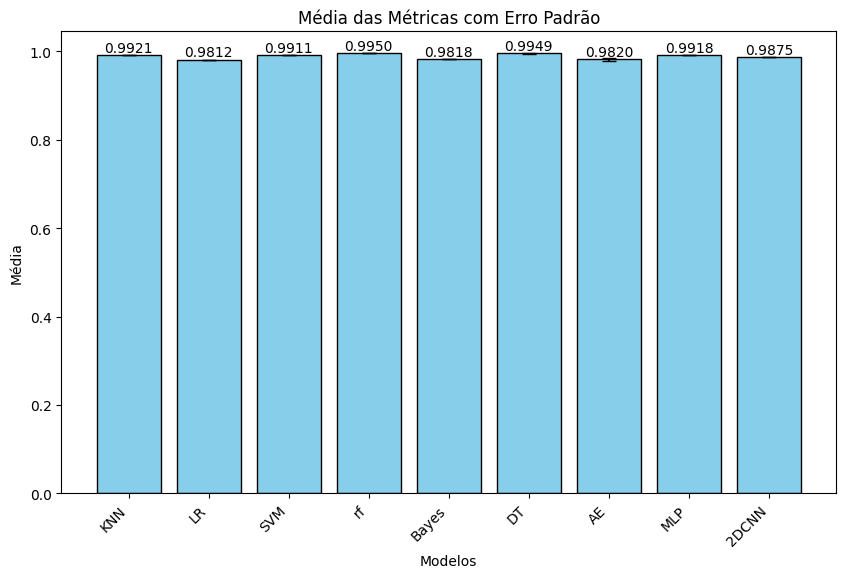

In [16]:
medias_accuracy = df_medias_unificadas['Accuracy'].to_numpy()
desvios_accuracy = df_desvios_unificados['Accuracy'].to_numpy()
modelos = df_medias_unificadas['Algorithm'].to_numpy()

plt.figure(figsize=(10,6))
bars = plt.bar(modelos, medias_accuracy, yerr=desvios_accuracy,  # Use as médias e desvios padrão
               capsize=5, color='skyblue', edgecolor='black')

plt.title("Média das Métricas com Erro Padrão")
plt.ylabel("Média")
plt.xlabel("Modelos")

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()  # Obtém a altura da barra (média)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

plt.show()
